# Supervised Machine Learning Models

In [14]:
from requests import get
import re

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate

import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
# included so I can add latex code
from IPython.display import display, Math, Latex


Importing the IMDB review data and applying the VADER sentiment analyzer:

In [15]:
reviews = pd.read_csv("imdb_reviews.csv")

sia = SentimentIntensityAnalyzer()

# making the predictions dichotomous so they match the original labels
reviews["vader"] =  [sia.polarity_scores(i)['compound'] for i in reviews['text']]
reviews["vader_prediction"] =  pd.to_numeric(reviews['vader']>=0.05)

When we left last class, we were using a set of user reviews from IMDB to check the accuracy of the VADER sentiment analysis lexicon. We found that, overall, it did better than a random guess, but still had plenty of errors. But can we do better? 

Maybe! Instead of using a lexicon to determine if things are positive or negative, we can make a machine learning model that infers the terms that are associated with positive or negative documents automatically. In general, even fairly simple machine learning models can beat lexicon based methods. 

In **supervised machine learning**, we are focused on finding the relationship between a **label y** and **features x**.

$$ y = f(x) $$

"Learning" is finding a function f that minimizes future error in recovering y. 

For supervised learning, we must have a y variable that we know. That is, we need to have a the y variable in our dataset, so that we can build our model and use that model to predict y for future data.


<div class="alert alert-block alert-info">
<b>Note</b> in machine learning circles its common to use terms - like "learning", "training", "memorization" etc. - that can give the misleading impression that we're dealing with models that have some kind of human-like reasoning capcity. This is a useful metaphor because the idea of "learning" is a lot more intuitive than "minimizing a loss function", but what we're really doing here is fitting statistical models. Some of these models are very sophisticated, but none are conscious, they don't think, they don't have free will, and this is true even for the most cutting edge technologies. Just something to keep in mind. 
</div>


We're going to compare the predictions from the VADER sentiment lexicon to another widely used machine learning model called a Naive Bayes classifier. 


The Naive Bayes model is *old* and extremely simple by modern standards, but its performs surprisingly well for simple classification tasks and is often used as a sort of baseline model for assessing other machine classifiers. It works by using Baye's Theorem to calculate the probability of each class (C_k in the formula below) given the predictors (X). 

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/52bd0ca5938da89d7f9bf388dc7edcbd546c118e)

It's considered "naive" because it assumes (incorrectly!) that each word is independent of all other words. This is another one of those clearly wrong assumptions that still works. 

### Pre-processing
We'll start by setting up our pre-processing steps to create the bag-of-words model for our Naive Bayes classifier. But we won't actually apply it to our data just yet:

In [16]:

text = reviews.text
# tokenizer that splits words
tokenizer = RegexpTokenizer(r'\w+')
# word stemming
stemmer = SnowballStemmer("english")
# english stop words
# stem the stopwords to ensure they're removedb
eng_stopwords = [tokenizer.tokenize(s)[0] for s in  stopwords.words('english')]

def tokenize(text):   
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in eng_stopwords]

vectorizer = CountVectorizer(analyzer= "word", # unit of features are single words rather then phrases of words 
                             tokenizer = tokenize,
                             ngram_range=(0,1), # Tokens are individual words for now
                             strip_accents='unicode',
                             max_df = 0.1, # maximum number of documents in which word j occurs. 
                             min_df = .0025 # minimum number of documents in which word j occurs. 
                            )

# Train and Test sets

One more caveat before we start: its extremely easy to make a model that "predict" data that's already part of the sample. A list of all U.S. presidential election winners in sequential order is a perfect predictor of all past elections, but its a terrible model for predicting the next one. Creating a model that predicts well inside a sample but poorly outside the sample is called "overfitting", and its a recurring problem for this kind of machine learning. In order to avoid that problem, we're going to randomly split our data into a training set that we'll feed to the model, and a validation (or training) set, that we'll use to assess our accuracy. 

The `train_test_split` function will do this for us. We'll use 80% of our data for training and the remaining 20% for validation: 

In [17]:
df_train, df_test = train_test_split(reviews, 
                                     test_size=0.20, # 20% of observations for validation
                                     random_state = 999) # this is a random process, so you want to set a random seed! 


In [18]:
# now we have a training set and testing set:
print(df_train.shape, df_test.shape)

(4000, 4) (1000, 4)


Now we can apply the the vectorization function to make our bag of words:

In [19]:
# running the count vectorizer function on our training data
X_train = vectorizer.fit_transform(df_train.text)

# get the names of the features for future use
features = vectorizer.get_feature_names_out()

# Note! We use transform instead of fit_transform to ensure that the vectorization function
# doesn't update anyhing based on the testing data
X_test = vectorizer.transform(df_test.text) 

# split the labels into train and test sets as well:
y_train = df_train.label
y_test = df_test.label

C:\Users\neilb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Now we'll fit our Naive Bayes model:

In [20]:
nb = MultinomialNB()
nb.fit(X_train, y_train)



MultinomialNB()

Now we can use the trained model to predict data in the testing set, and compare the results in a confusion matrix:

In [21]:
preds = nb.predict(X_test)

pd.crosstab(y_test, preds,  margins=True).rename_axis(index = 'Truth', columns='Predictions')


Predictions,0,1,All
Truth,,,
0,422,77,499
1,85,416,501
All,507,493,1000


`scikit-learn` has a built in function that will allow us to get some additional information about our model performance. 



In [22]:
print(classification_report(y_test, preds, 
                            # add target_names to show labels in the report:
                            target_names=['negative', 'positive']))

# add cohen's kappa and balanced accuracy
print("cohens kappa: ", cohen_kappa_score(y_test, preds))
print("balanced accuracy: ", balanced_accuracy_score(y_test, preds))

              precision    recall  f1-score   support

    negative       0.83      0.85      0.84       499
    positive       0.84      0.83      0.84       501

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

cohens kappa:  0.6760090717459911
balanced accuracy:  0.8380153520614082


Here's how we can intepret these metrics:

| **metric**                  | Description                                                                                                                               |
|-----------------------------|-------------------------------------------------------------------------------------------------------------------------------------------|
| **accuracy** | % of predictions that are accurate                                                                                                        |
| **recall**                  | % of actually positive reviews that were correctly classified as positive                                                                 |
| **precision**               | % of predicted positive reviews that were actually positive                                                                               |
| **f-1**                     | Harmonic mean of precision and recall. Used as an overall measure of model performance. The maximum score is 1. Scores above .5 are poor. |
| **Cohen's Kappa**           | Measures how well the model performs relative to a model based on the marginal probabilities of each class. Higher is better.             |
| **Balanced Accuracy**       | Accuracy score after accounting for imbalance between each class                                                                          |

<span style="color:red"> Question 1: Create a confusion matrix and classification report for the `vader_prediction` column in the validation data  <span/>

So how does the naive bayes model perform relative to VADER? More importantly why is there a difference? Primarily, this probably comes down to the differences in context: there are a lot of terms that indicate negative views in the IMDB corpus that probably wouldn't indicate negative views in other contexts. We can get a sense of this by extracting some of the most important features from the model.



In [23]:
# get the probability of positive and negative classes
prob_neg = df_train['label'].value_counts(normalize=True)[0]
prob_pos = df_train['label'].value_counts(normalize=True)[1]
# making a data frame with the 
df_nbf = pd.DataFrame()
df_nbf.index = features
vals= np.e**(nb.feature_log_prob_[0, :])
# np.e exponentiates the logged odds, so this turns them back into probabilities 
df_nbf['pos'] = np.e**(nb.feature_log_prob_[1, :]) # log probability for negative class
df_nbf['neg'] = np.e**(nb.feature_log_prob_[0, :]) # log probability for positive class
# terms with the highest ratio of association with one class
# p(positive|word)/p(negative|word) * (p(positive)/p(negative))
df_nbf['odds_positive'] = (df_nbf['pos']/df_nbf['neg'])*(prob_pos /prob_neg)


Now we can look at some features associated with positive or negative reviews

In [24]:
df_nbf.sort_values('odds_positive',ascending=False)['odds_positive']


matthau          19.393327
heartbreaking    19.393327
nyc              16.331223
depardieu        15.310521
discovering      13.269119
                   ...    
downhill          0.046396
uwe               0.042529
wasting           0.040828
miscast           0.035197
boll              0.030930
Name: odds_positive, Length: 5531, dtype: float64

And with a little reshaping, we can plot them

[Text(0.5, 0, 'Strength of association with positive\n vs. negative reviews'),
 Text(0, 0.5, 'term')]

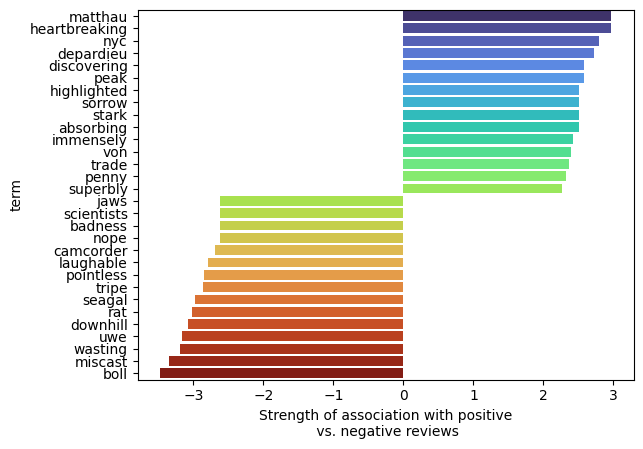

In [25]:
top = df_nbf.sort_values('odds_positive',ascending=False).reset_index()
top_bottom = pd.concat([top.iloc[:15], top.iloc[-15:]])
ax = sns.barplot(data=top_bottom,
                 y= 'index',    
                 hue='index',
                x=np.log(top_bottom['odds_positive']),dodge=False, palette='turbo')
ax.set(xlabel='Strength of association with positive\n vs. negative reviews', ylabel='term')


The results here should give you a rough idea of how and why the Naive Bayes model is able to outperform VADER: there are a number of terms - particularly the names of actors and directors - that are strongly associated with negative or positive reviews in this corpus that wouldn't really be seen as indicating negativity elsewhere. It might also give you a sense of one of the key risks of using machine learning approaches: its easy to unintentionally fit models that make inferences that might reflect biases - including cultural, racial, or gender biases - that we don't want to perpetuate. 

# Improving the processing

Naive Bayes is generally considered a baseline model for classification, but sometimes we can improve our results with some additional pre-processing. We've already explored some options for pre-processing text data in previous classes: we can do things like lemmatization, using n-grams, or applying a weighting scheme like tf-idf can make predictive models more effective. We skipped all of those steps when building this model, so. before we move on to a more complicated method, maybe we should see if we can do better by cleaning the data up a little.


<span style="color:red"> Question 2: Try changing the pre-processing steps for the reviews data. What steps you choose here is up to you. Fit a new naive bayes classifer on the processed data, and assess your results on the held-out data. <span/>

## Fitting a different model

Can we do better with a better model? The Naive Bayes classifier, after all, fails to account for correlations between predictors and can't really handle interactive relationships. We can compare our results to a support vector machine to see if we get better results. 




In [40]:
 
from sklearn.svm import SVC

model = SVC()
model.fit(X_train,y_train)



SVC()

In [41]:
pred = model.predict(X_test)
print(classification_report(y_test, pred, 
                            # add target_names to show labels in the report:
                            target_names=['negative', 'positive']))

# add cohen's kappa and balanced accuracy
print("cohens kappa: ", cohen_kappa_score(y_test, preds))
print("balanced accuracy: ", balanced_accuracy_score(y_test, preds))

              precision    recall  f1-score   support

    negative       0.88      0.80      0.84       499
    positive       0.82      0.90      0.86       501

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

cohens kappa:  0.6760090717459911
balanced accuracy:  0.8380153520614082


Next week we'll look at a newer and more flexible strategy for classifying texts (and other things) using neural network models. 

## K-fold cross validation

Although its unlikely, given how many test examples we have, we might want to make sure that our performance with this model isn't just a function of random chance, and we also want to avoid over-fitting to a single test data set. To avoid this problem, we'll often use k-fold cross validation. In K-fold cross validation, we separate the data into "K" equally sized groups, and then loop through the folds using each one as the validation data and all of the remaining observations as training data. Scikit-learn has an easy method for running k-fold cross validation and getting some overall metrics:

In [ ]:
all_reviews = vectorizer.fit_transform(reviews.text)
nbayes = MultinomialNB()

In [ ]:
cross_val = cross_validate(nbayes, 
               all_reviews, 
               reviews.label, 
               cv=40,
               scoring =['f1', 'balanced_accuracy']
              
              )
cross_val

In [ ]:
pd.DataFrame(cross_val)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [ ]:
onehot = OneHotEncoder() 
ct = ColumnTransformer(
    [("text_preprocess", vectorizer, "text"),
     ("vader_preprocess", onehot , ["vader_prediction"])])
X_trans_train = ct.fit_transform(df_train)   
X_trans_test = ct.transform(df_test)  

In [ ]:
nb = MultinomialNB()
nb.fit(X_trans_train, y_train)

In [ ]:
preds = nb.predict(X_trans_test)

pd.crosstab(y_test, preds,  margins=True).rename_axis(index = 'Truth', columns='Predictions')

print(classification_report(y_test, preds, 
                            # add target_names to show labels in the report:
                            target_names=['negative', 'positive']))

# add cohen's kappa and balanced accuracy
print("cohens kappa: ", cohen_kappa_score(y_test, preds))
print("balanced accuracy: ", balanced_accuracy_score(y_test, preds))
